# Assignment 4: Return Predictions From Trade Flow

# 1. Introduction:

This work is assessing the trade flow to generate profit opportunities in three cryptotoken markets. Trade flow is a running tally of signed trade sizes where the sign is defined as 1 if the trade is seller-initiated and -1 if it was buyer-initiated. All reported trades within the last time period of length tau are examined for the profit-generating purpose. Three crypto token pairs considered for the analysis are ETH-BTC, BTC-USD and ETH-USD.

Import all the python packages needed:

In [1]:
import datetime
import requests
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import plotnine as p9
import functools
import itertools
import random
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from scipy.stats import probplot
from datetime import datetime
from io import BytesIO
from io import StringIO
from zipfile import ZipFile
from pandas.plotting import register_matplotlib_converters
from plotnine import ggplot, aes, geom_line, labs, scale_x_date, theme_minimal, element_text, theme, geom_ribbon, geom_point
from mizani.breaks import date_breaks
from mizani.formatters import date_format
register_matplotlib_converters()

# 2. Various functions that is to be used for the analysis:

# Trade Flow Calculation Function (tau interval):

In [2]:
def trade_flow(df, time_col='timestamp_utc_nanoseconds', size_col='SizeBillionths', sign_col='Side', tau = '10s'):
    """
    Calculate the trade flow based on the cumulative size within a given time interval (tau).

    Parameters:
    - df: DataFrame containing the trade data.
    - time_col: The name of the column containing the timestamp in nanoseconds.
    - size_col: The name of the column containing the trade sizes.
    - sign_col: The name of the column containing the trade side (buy/sell indicator).
    - tau: The time interval as a string, e.g. '10s' for 10 seconds.

    Returns:
    - DataFrame with a new 'trade_flow' column representing the trade flow.
    """
    df = df.copy()
    
    # Creating the signed size column
    df['cum_size_billionths'] = df[size_col] * np.sign(df[sign_col])
    
    # Convert the timestamp to a datetime index
    df['timestamp'] = pd.to_datetime(df[time_col], unit='ns')

    # Ensure the data is sorted by timestamp
    df.sort_values(by=time_col, inplace=True)

    # Set the timestamp as the index
    df.set_index('timestamp', inplace=True)

    # Calculate the trade flow using a rolling window and sum within the interval tau
    df['trade_flow'] = df['cum_size_billionths'].rolling(tau, closed='left').sum()
    
    df['trade_flow'] = df['trade_flow']/ 1e9
    
    # Reset the index to remove the timestamp from the index position
    df.reset_index(drop=True, inplace=True)
    
    return df

# T-second Forward Return Calculation Function:

In [3]:
def T_second_forward_return(trades, book, trade_price_col = 'PriceMillionths', mid_price_col = 'Mid', time_col = 'timestamp_utc_nanoseconds', T = '5s'):
    """
    Calculate the T-second forward return within a given forward time interval (T).

    Parameters:
    - df1: DataFrame containing the trade data.
    - df2: DataFrame containing the book data.
    - trade_price: The name of the column containing trade price at time t.
    - mid_price_tplusT: The name of the column containing trade price at time t+T.
    - time_col: The name of the column containing the timestamp in nanoseconds.
    - T: The forward time interval as a string, e.g. '5s' for 5 seconds.

    Returns:
    - DataFrame with a new 'T_second_forward_return' column representing the trade flow.
    """
    # Create a temporary 'timestamp' column for both trades and book data
    trades['timestamp'] = pd.to_datetime(trades[time_col], unit='ns')
    book['timestamp'] = pd.to_datetime(book[time_col], unit='ns')
    
    # Set the temporary 'timestamp' column as the index for both DataFrames
    trades.set_index('timestamp', inplace=True)
    book.set_index('timestamp', inplace=True)

    # Forward fill the book data to the timestamps of the trades data plus T seconds
    later = book.reindex(trades.index + pd.to_timedelta(T), method='ffill')
    later.index = trades.index

    # Calculate the T-second forward return
    trades['T_second_forward_return'] = (later[mid_price_col] / trades[trade_price_col]) - 1

    # Reset the index to convert the datetime index back into a column and drop the temporary 'timestamp' column
    trades.reset_index(drop=True, inplace=True)
    
    # Drop the temporary 'timestamp' column from the book DataFrame as well
    book.reset_index(drop=True, inplace=True)
    
    return trades
    
        

# Function to create the training and test split datasets:

In [4]:
def train_test_data(trades, train_size=0.4):
    """
    Split the trades dataset into training and testing sets.

    Parameters:
    - trades: DataFrame containing the trade data.
    - train_size: The proportion of the dataset to include in the train split.

    Returns:
    - A tuple containing the training set and the testing set.
    """
    # Calculate the index to split on
    split_index = int(len(trades) * train_size)
    
    # Split the DataFrame into training and testing sets
    train_set = trades[:split_index]
    test_set = trades[split_index:]
    
    return train_set, test_set

# Regression function to find coefficient Beta of regression:

In [5]:
def regression(train_data, test_data, flow_col='trade_flow', return_col='T_second_forward_return'):
    """
    Fit a regression model without an intercept and predict returns on the test set.
    """
    # Ensure there are no NaN values in the columns used for regression
    train_data = train_data.dropna(subset=[flow_col, return_col])
    test_data = test_data.dropna(subset=[flow_col])
    
    # Fit regression model on the training set without a constant
    model = OLS(train_data[return_col], train_data[flow_col]).fit()
    
    # Get the coefficient of regression
    beta = model.params[flow_col]
    
    # Predict returns on the test set
    test_data['predicted_return'] = model.predict(test_data[flow_col])
    
    # Calculate the R-squared value
    r_squared = model.rsquared_adj
    
    return beta, test_data, r_squared

# Function to find trade Signals:

In [6]:
def find_trade_signals(test_data, predicted_return_col='predicted_return', j=0.000001):
    """
    Find trade signals based on the threshold j.
    """
    # Identify potential trade signals where the absolute predicted return is greater than the threshold j
    test_data['trade_signal'] = test_data[predicted_return_col].abs() > j
    
    return test_data

# Function to create PnL (without trading costs) dataframe:

In [7]:
def calculate_pnl(test_pred, book, T, position_size=0.05):
    """
    Calculate and accumulate P&L for trade signals within interval T.

    Parameters:
    - test_pred: DataFrame containing test predictions with trade signals.
    - book: DataFrame containing book data with mid prices.
    - T: Time interval in seconds as a string, e.g., '5s'.
    - position_size: Multiplier to determine the position size.

    Returns:
    - pnl_df: DataFrame containing P&L information.
    """
    # Filter for trade signals
    signals = test_pred[test_pred['trade_signal']]

    # Merge book data to get the mid price at the signal's timestamp
    signals = signals.merge(book[['timestamp_utc_nanoseconds', 'Mid']], on='timestamp_utc_nanoseconds', how='left')
           
    signals['position'] = position_size * signals['SizeBillionths'] * signals['Side'].apply(np.sign)

    # Get the price at the end of the interval T
    signals['timestamp_end'] = pd.to_datetime(signals['timestamp_utc_nanoseconds'], unit='ns') + pd.to_timedelta(T)
    book['timestamp'] = pd.to_datetime(book['timestamp_utc_nanoseconds'], unit='ns')
    book.set_index('timestamp', inplace=True)
    
    signals['mid_price_end'] = signals['timestamp_end'].apply(lambda x: book.at[x, 'Mid'] if x in book.index else np.nan)

    # Calculate P&L for each T interval
    signals['plT'] = signals['position'] * (signals['mid_price_end'] - signals['PriceMillionths'])

    # Accumulate P&L over all intervals
    signals['acc_qty'] = signals['position'].cumsum().shift(fill_value = 0)
    signals['acc_plT'] = signals['plT'].cumsum().shift(fill_value=0)

    # Create the P&L DataFrame
    pnl_df = signals[['timestamp_utc_nanoseconds', 'position', 'PriceMillionths', 'Mid', 'acc_qty', 'plT', 'acc_plT']].copy()

    pnl_df['Mid'].fillna(method='ffill', inplace=True)
    
    # Convert 'PriceMillionths' to actual price
    pnl_df['PriceMillionths'] = pnl_df['PriceMillionths'] / 1e6

    # Assuming you already have a 'position' column calculated based on the original size
    # and you want to adjust it using the actual size
    pnl_df['position'] = pnl_df['position'] / 1e9

    pnl_df['Mid'] = pnl_df['Mid'] / 1e6  
    pnl_df['plT'] = pnl_df['position'] * (pnl_df['Mid'] - pnl_df['PriceMillionths'])
    pnl_df['acc_plT'] = pnl_df['plT'].cumsum().shift(fill_value=0)

    
    return pnl_df


# Function to create PnL (with trading costs) dataframe:

Trading costs for the pair has been assumed to be 0.2%.

In [8]:
def calculate_pnl_with_tc(test_pred, book, T, position_size=0.05):
    """
    Calculate and accumulate P&L for trade signals within interval T.

    Parameters:
    - test_pred: DataFrame containing test predictions with trade signals.
    - book: DataFrame containing book data with mid prices.
    - T: Time interval in seconds as a string, e.g., '5s'.
    - position_size: Multiplier to determine the position size.

    Returns:
    - pnl_df: DataFrame containing P&L information.
    """
    # Filter for trade signals
    signals = test_pred[test_pred['trade_signal']]

    # Merge book data to get the mid price at the signal's timestamp
    signals = signals.merge(book[['timestamp_utc_nanoseconds', 'Mid']], on='timestamp_utc_nanoseconds', how='left')
           
    signals['position'] = position_size * signals['SizeBillionths'] * signals['Side'].apply(np.sign)

    # Get the price at the end of the interval T
    signals['timestamp_end'] = pd.to_datetime(signals['timestamp_utc_nanoseconds'], unit='ns') + pd.to_timedelta(T)
    book['timestamp'] = pd.to_datetime(book['timestamp_utc_nanoseconds'], unit='ns')
    book.set_index('timestamp', inplace=True)
    
    signals['mid_price_end'] = signals['timestamp_end'].apply(lambda x: book.at[x, 'Mid'] if x in book.index else np.nan)

    # Calculate P&L for each T interval
    signals['plT'] = signals['position'] * (signals['mid_price_end'] - signals['PriceMillionths'])

    # Accumulate P&L over all intervals
    signals['acc_qty'] = signals['position'].cumsum().shift(fill_value = 0)
    signals['acc_plT'] = signals['plT'].cumsum().shift(fill_value=0)

    # Create the P&L DataFrame
    pnl_df = signals[['timestamp_utc_nanoseconds', 'position', 'PriceMillionths', 'Mid', 'acc_qty', 'plT', 'acc_plT']].copy()

    pnl_df['Mid'].fillna(method='ffill', inplace=True)
    
    # Convert 'PriceMillionths' to actual price
    pnl_df['PriceMillionths'] = pnl_df['PriceMillionths'] / 1e6

    # Assuming you already have a 'position' column calculated based on the original size
    # and you want to adjust it using the actual size
    pnl_df['position'] = pnl_df['position'] / 1e9

    pnl_df['Mid'] = pnl_df['Mid'] / 1e6  
    pnl_df['plT'] = pnl_df['position'] * (pnl_df['Mid'] - pnl_df['PriceMillionths'])*0.998
    pnl_df['acc_plT'] = pnl_df['plT'].cumsum().shift(fill_value=0)

    
    return pnl_df


# Function to calculate Sharpe ratio, Max Drawdowns, Downside Deviations and Cumulative PnL plot:

In [9]:
def calculate_pnl_stats(pnl, T):
    # Set the timestamp as the index
    pnl['timestamp'] = pd.to_datetime(pnl['timestamp_utc_nanoseconds'], unit='ns')
    pnl.set_index('timestamp', inplace=True)

    # Group and sum P&L into T-second bins
    grouped_plT = pnl['plT'].resample(T).sum()

    # Calculate Sharpe Ratio (assuming risk-free rate is 0)
    sharpe_ratio = grouped_plT.mean() / grouped_plT.std() if grouped_plT.std() != 0 else np.nan

    # Calculate maximum drawdown
    running_max = np.maximum.accumulate(grouped_plT.cumsum())
    drawdown = running_max - grouped_plT.cumsum()
    max_drawdown = drawdown.max()

    # Calculate downside deviations (using 0 as the minimum acceptable return)
    downside_deviations = grouped_plT[grouped_plT < 0].std() if not grouped_plT[grouped_plT < 0].empty else np.nan

    # Plot cumulative P&L over time
    cumulative_plT = grouped_plT.cumsum()
    cumulative_plT.plot()
    plt.title('Cumulative P&L over Time')
    plt.xlabel('Time')
    plt.ylabel('Cumulative P&L')
    plt.show()
    
    pnl.reset_index(drop=True, inplace=True)
    
    return sharpe_ratio, max_drawdown, downside_deviations, cumulative_plT, grouped_plT



# Reliability and Stability of beta:

In [10]:
def analyze_beta_stability(beta_df):
    """
    Analyze the stability of beta values.
    
    Parameters:
    beta_df (DataFrame): DataFrame containing 'tau', 'T', and 'beta' columns.

    Returns:
    dict: Dictionary containing key metrics for beta stability.
    """
    # Coefficient of Variation
    cv = beta_df['beta'].std() / beta_df['beta'].mean()

    # Standard Deviation
    beta_std = beta_df['beta'].std()

    # Range
    beta_range = beta_df['beta'].max() - beta_df['beta'].min()

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=beta_df, x='beta')
    plt.title('Box Plot of Beta Values')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.distplot(beta_df['beta'], bins=30)
    plt.title('Distribution of Beta Values')
    plt.show()

    # Return the key metrics
    return {
        'Coefficient of Variation': cv,
        'Beta Standard Deviation': beta_std,
        'Beta Range': beta_range
    }

# Pipeline to get beta for different tau and T:

In [11]:
def pipeline(trades, book, time_col='timestamp_utc_nanoseconds', size_col='SizeBillionths', sign_col='Side', trade_price_col = 'PriceMillionths', mid_price_col = 'Mid', tau = '10s', T = '5s', train_size=0.4):
    # Step 1: Calculate trade flow
    trades = trade_flow(trades, time_col='timestamp_utc_nanoseconds', size_col='SizeBillionths', sign_col='Side', tau = tau)
    
    # Step 2: Calculate T-second forward return
    trades = T_second_forward_return(trades, book, trade_price_col = 'PriceMillionths', mid_price_col = 'Mid', time_col = 'timestamp_utc_nanoseconds', T = T)
    
    # Step 3: Split data into train and test
    train, test = train_test_data(trades, train_size = train_size)
    
    # Step 4: Perform regression and get beta
    beta, test_data, r_squared = regression(train, test, flow_col='trade_flow', return_col='T_second_forward_return')
    
    return beta


# 3. Analysis of ETH-BTC pair:

Reading the trade and book data for ETH-BTC pair:

In [12]:
#Reading the trades data ETH-BTC
trades_file_path = r'C:\Users\nihar\Desktop\QTS\Week 4 Tick Level Data\Assignment 4\trades_narrow_ETH-BTC_2023.delim.gz'
trades_ETH_BTC = pd.read_csv(trades_file_path, delimiter='\t')

In [13]:
trades_ETH_BTC.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1674521345955989000,1674521346020758000,70950,259656510,1
1,1674521345984460000,1674521346050573000,70950,140800,1
2,1674521348097555000,1674521348159815000,70950,53582550,-1
3,1674521352535174000,1674521352601911000,70940,207220,-1
4,1674521546128872000,1674521546201920000,70950,990630,1


In [14]:
trades_ETH_BTC.shape

(1958, 5)

In [15]:
#Reading the book data ETH-BTC
book_narrow_file_path = r'C:\Users\nihar\Desktop\QTS\Week 4 Tick Level Data\Assignment 4\book_narrow_ETH-BTC_2023.delim.gz'
book_narrow_ETH_BTC = pd.read_csv(book_narrow_file_path, delimiter='\t')

In [16]:
book_narrow_ETH_BTC.shape

(216027, 11)

In [17]:
book_narrow_ETH_BTC.head()

,Ask1PriceMillionths,Bid1PriceMillionths,Ask1SizeBillionths,Bid1SizeBillionths,Ask2PriceMillionths,Bid2PriceMillionths,Ask2SizeBillionths,Bid2SizeBillionths,received_utc_nanoseconds,timestamp_utc_nanoseconds,Mid
0,70970,70940,2297617430,48603840,70980,70930,13399602090,14206845420,1674521275893722000,1674521275066931000,70955.0
1,70970,70940,2297617430,48603840,70980,70930,13399602090,14206845420,1674521278094853200,1674521278159732000,70955.0
2,70970,70940,2297617430,48603840,70980,70930,13399602090,14996845420,1674521278106928800,1674521278171531000,70955.0
3,70970,70940,1507617430,48603840,70980,70930,10629602090,14996845420,1674521278108897000,1674521278173961000,70955.0
4,70970,70940,1507617430,48603840,70980,70930,10629602090,14996845420,1674521278122113000,1674521278183694000,70955.0


Sorting the datasets by timestamps and remove the duplicates by keeping the latest value:

In [18]:
# Sort by 'timestamp_utc_nanoseconds' in descending order to ensure the latest entries are first
trades_ETH_BTC.sort_values(by='timestamp_utc_nanoseconds', ascending=False, inplace=True)

trades_ETH_BTC.drop_duplicates(subset=['timestamp_utc_nanoseconds'], keep='first', inplace=True)

trades_ETH_BTC.sort_values(by='timestamp_utc_nanoseconds', ascending=True, inplace=True)


# Calling the trade flow function to calculate trade flow for ETH-BTC pair:

In [19]:
trades_ETH_BTC = trade_flow(trades_ETH_BTC,  time_col='timestamp_utc_nanoseconds', size_col='SizeBillionths', sign_col='Side', tau='60s')

# Calculating the T-second forward returns:

In [20]:
trades_ETH_BTC = T_second_forward_return(trades_ETH_BTC, book_narrow_ETH_BTC, trade_price_col = 'PriceMillionths', mid_price_col = 'Mid', time_col = 'timestamp_utc_nanoseconds', T = '50s')

In [21]:
trades_ETH_BTC.shape

(1844, 8)

In [22]:
trades_ETH_BTC.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return
0,1674521345955989000,1674521346020758000,70950,259656510,1,259656510,NaN,-0.000070
1,1674521345984460000,1674521346050573000,70950,140800,1,140800,0.259657,-0.000070
2,1674521348097555000,1674521348159815000,70950,53582550,-1,-53582550,0.259797,-0.000070
3,1674521352535174000,1674521352601911000,70940,207220,-1,-207220,0.206215,0.000070
4,1674521546128872000,1674521546201920000,70950,990630,1,990630,NaN,0.000141


# Looking at the data to check for nan values before regression:

In [23]:
trades_ETH_BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844 entries, 0 to 1843
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   received_utc_nanoseconds   1844 non-null   int64  
 1   timestamp_utc_nanoseconds  1844 non-null   int64  
 2   PriceMillionths            1844 non-null   int64  
 3   SizeBillionths             1844 non-null   int64  
 4   Side                       1844 non-null   int64  
 5   cum_size_billionths        1844 non-null   int64  
 6   trade_flow                 1574 non-null   float64
 7   T_second_forward_return    1844 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 115.4 KB


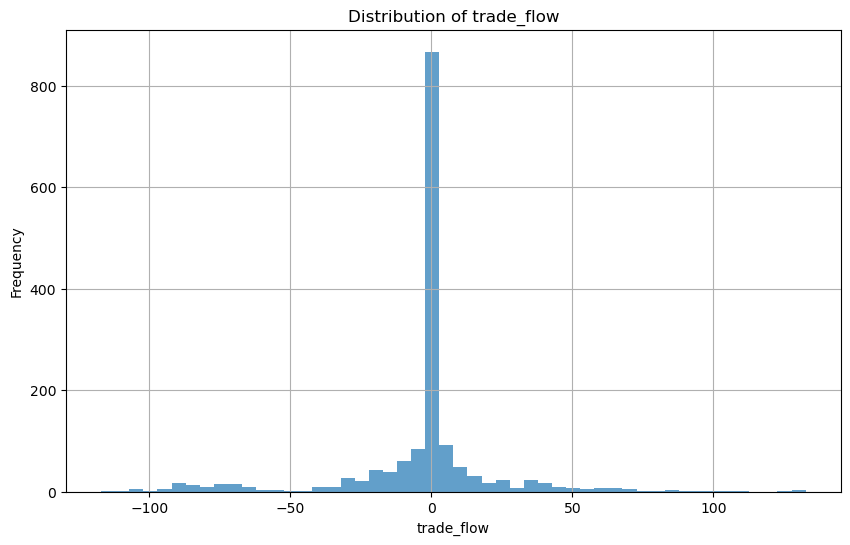

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(trades_ETH_BTC['trade_flow'].dropna(), bins=50, alpha=0.7)
plt.title('Distribution of trade_flow')
plt.xlabel('trade_flow')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Fill the nan values for trade flow by keeping the distribution of trade flow the same:

In [25]:
# Fill NaN values in 'trade_flow' with the median value
median_flow = trades_ETH_BTC['trade_flow'].median()
trades_ETH_BTC['trade_flow'].fillna(median_flow, inplace=True)

In [26]:
trades_ETH_BTC.describe()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return
count,1.844000e+03,1.844000e+03,1844.000000,1.844000e+03,1844.000000,1.844000e+03,1844.000000,1844.000000
mean,1.674591e+18,1.674591e+18,69645.151844,7.840369e+08,-0.068872,6.070004e+07,-2.253765,0.000256
std,3.928364e+13,3.928363e+13,1115.777702,1.833362e+09,1.494837,1.993132e+09,24.779757,0.000880
min,1.674521e+18,1.674521e+18,68220.000000,1.000000e+01,-12.000000,-1.801439e+10,-117.129680,-0.002354
25%,1.674566e+18,1.674566e+18,68440.000000,2.000000e+07,-1.000000,-8.285059e+07,-0.959172,-0.000142
50%,1.674597e+18,1.674597e+18,69780.000000,8.335000e+07,1.000000,3.165000e+03,-0.000230,0.000071
75%,1.674622e+18,1.674622e+18,70760.000000,8.000000e+08,1.000000,8.375286e+07,0.655033,0.000364
max,1.674659e+18,1.674659e+18,71130.000000,1.801439e+10,6.000000,1.690000e+10,132.766599,0.004164


Splitting the dataset into training and test data:

In [27]:
train_ETH_BTC, test_ETH_BTC = train_test_data(trades_ETH_BTC, train_size=0.4)

In [28]:
train_ETH_BTC.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return
0,1674521345955989000,1674521346020758000,70950,259656510,1,259656510,-0.000230,-0.000070
1,1674521345984460000,1674521346050573000,70950,140800,1,140800,0.259657,-0.000070
2,1674521348097555000,1674521348159815000,70950,53582550,-1,-53582550,0.259797,-0.000070
3,1674521352535174000,1674521352601911000,70940,207220,-1,-207220,0.206215,0.000070
4,1674521546128872000,1674521546201920000,70950,990630,1,990630,-0.000230,0.000141


Checking for percentage for training and test data:

In [29]:
print(f"Training set length: {len(train_ETH_BTC)}")
print(f"Testing set length: {len(test_ETH_BTC)}")

Training set length: 737
Testing set length: 1107


# Calling the regression function:

In [30]:
beta_ETH_BTC, test_pred_ETH_BTC, r2_ETH_BTC = regression(train_ETH_BTC, test_ETH_BTC, flow_col='trade_flow', return_col='T_second_forward_return')

In [31]:
r2_ETH_BTC

0.06812621504757288

In [32]:
beta_ETH_BTC

2.546613919319768e-06

# Calculate beta for various tau and T pairs:

In [33]:
tau_T_pairs = [('5s', '1s'), ('10s', '5s'), ('15s', '10s'), ('20s', '15s'), ('25s', '20s'), ('30s', '25s'), ('35s', '30s'), ('40s', '30s'), ('50s', '40s'), ('60s', '50s'), ('100s', '80s')]

In [34]:
beta_values = {}

# Loop through each pair of tau and T
for tau, T in tau_T_pairs:
    beta = pipeline(trades_ETH_BTC, book_narrow_ETH_BTC, 
                    time_col='timestamp_utc_nanoseconds',
                    size_col='SizeBillionths', 
                    sign_col='Side', 
                    trade_price_col='PriceMillionths', 
                    mid_price_col='Mid', 
                    tau=tau, T=T, 
                    train_size=0.4)
    # Store the beta value in the dictionary
    beta_values[(tau, T)] = beta

In [35]:
beta_records = [{'tau': tau, 'T': T, 'beta': beta} for (tau, T), beta in beta_values.items()]

# Create a DataFrame
beta_df = pd.DataFrame(beta_records)

# Display the DataFrame
print(beta_df)


     tau    T          beta
0     5s   1s -2.962279e-07
1    10s   5s  7.247079e-07
2    15s  10s  3.779859e-07
3    20s  15s  6.386201e-07
4    25s  20s  9.959871e-07
5    30s  25s  1.356218e-06
6    35s  30s  1.836970e-06
7    40s  30s  1.428171e-06
8    50s  40s  1.615880e-06
9    60s  50s  2.546615e-06
10  100s  80s  1.105718e-06


For various pairs of tau and T beta has been calculated and we can see that beta increase as we increase the trading interval and T-second and then decrease after some value.

# Looking at the reliability and stability of beta:

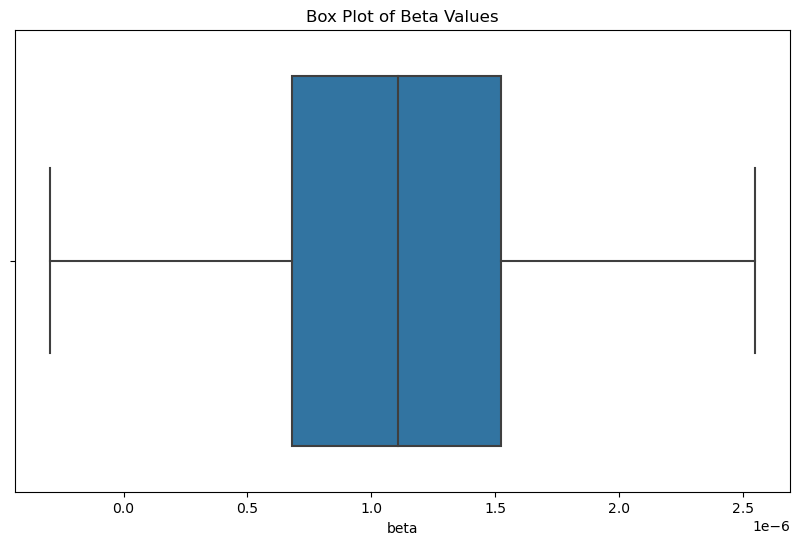

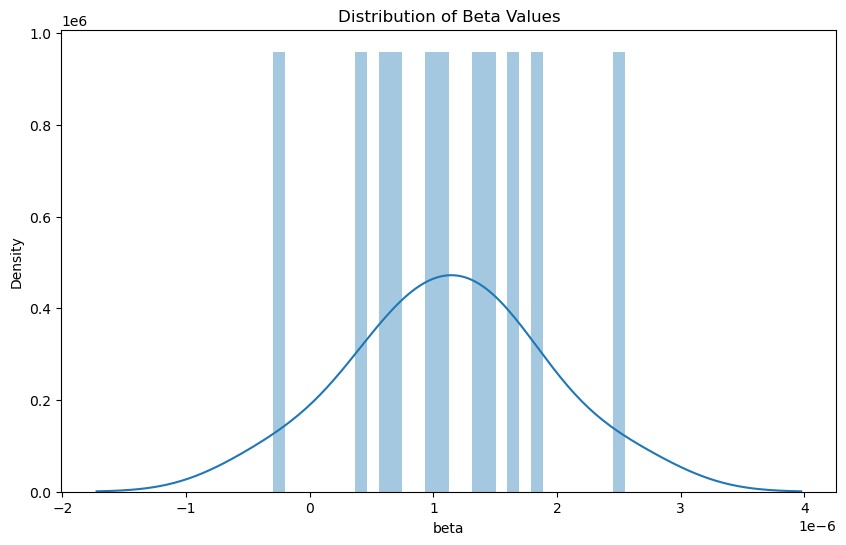

{'Coefficient of Variation': 0.6855603291589328, 'Beta Standard Deviation': 7.684910547474148e-07, 'Beta Range': 2.8428431530115424e-06}


In [36]:
rel_stab_beta = analyze_beta_stability(beta_df)
print(rel_stab_beta)

# Various beta for different training sizes by considering best tau and T:

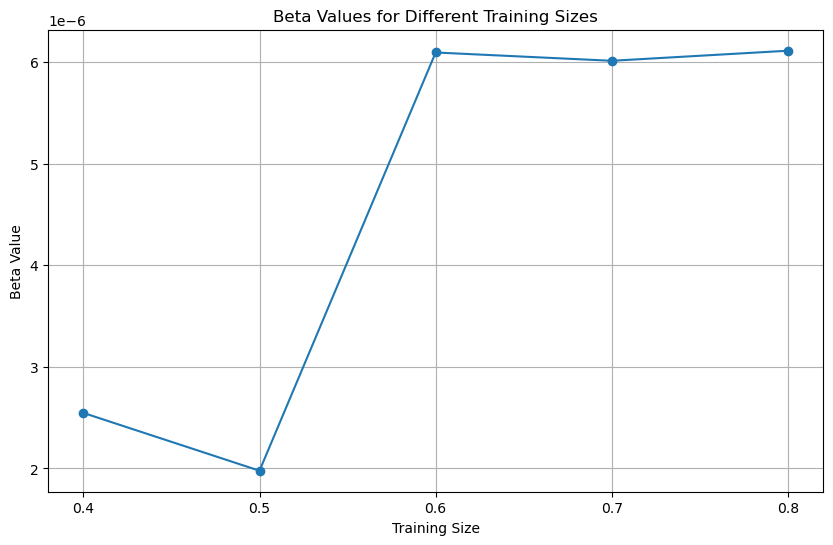

In [37]:
best_tau = '60s'
best_T = '50s'

# Define the range of training sizes
train_sizes = [0.4, 0.5, 0.6, 0.7, 0.8]

# Initialize an empty list to store the results
beta_values = []

# Loop over the training sizes
for train_size in train_sizes:
    beta = pipeline(trades_ETH_BTC, book_narrow_ETH_BTC, 
                    time_col='timestamp_utc_nanoseconds',
                    size_col='SizeBillionths', 
                    sign_col='Side', 
                    trade_price_col='PriceMillionths', 
                    mid_price_col='Mid', 
                    tau=best_tau, T=best_T, 
                    train_size=train_size)
    beta_values.append(beta)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, beta_values, marker='o')
plt.title('Beta Values for Different Training Sizes')
plt.xlabel('Training Size')
plt.ylabel('Beta Value')
plt.xticks(train_sizes)
plt.grid(True)
plt.show()

We can see from the plot that the beta value increases as we increase the training dataset size.

# Look at the return prediction from the regression function:

In [38]:
test_pred_ETH_BTC


,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return,predicted_return
737,1674587748740388000,1674587748747246000,70570,2760859870,2,2760859870,9.073765,0.000000,2.310738e-05
738,1674587748814116000,1674587748789907000,70580,996597300,2,996597300,11.834625,-0.000142,3.013822e-05
739,1674587772942539000,1674587772942213000,70580,16200000,-1,-16200000,3.838090,-0.000142,9.774132e-06
740,1674587777044862000,1674587777052452000,70580,572380,1,572380,3.821890,-0.000142,9.732877e-06
741,1674587790360439000,1674587790372638000,70570,2519000,-1,-2519000,3.822462,-0.000071,9.734335e-06
...,...,...,...,...,...,...,...,...,...
1839,1674659220547379000,1674659220556309000,68470,170840,-1,-170840,2.700062,-0.000073,6.876017e-06
1840,1674659233921521000,1674659233932491000,68480,83190000,-1,-83190000,-0.004451,-0.000219,-1.133457e-08
1841,1674659254067551000,1674659254076843000,68490,77766040,1,77766040,-0.083361,-0.000219,-2.122879e-07
1842,1674659254799097000,1674659254810416000,68500,32440000,-1,-32440000,-0.005595,-0.000365,-1.424780e-08


In [39]:
test_pred_ETH_BTC['predicted_return'].describe()

count    1.107000e+03
mean     4.888157e-06
std      3.497980e-05
min     -9.473834e-05
25%     -1.602434e-06
50%     -5.857212e-10
75%      3.620268e-06
max      1.641632e-04
Name: predicted_return, dtype: float64

# Deciding j:

j has been decided in such a way that trade can be performed 60% of the time:

In [40]:
# Calculate the absolute values of the predicted returns
absolute_predicted_returns = test_pred_ETH_BTC['predicted_return'].abs()

# Find the value of j such that 70% of the predicted returns are greater than j
j_ETH_BTC = np.percentile(absolute_predicted_returns, 40)  # 40th percentile since we want the lower threshold

j_ETH_BTC

1.0574236727938437e-06

Finding trade signals for the decided j:

In [41]:
test_pred_ETH_BTC = find_trade_signals(test_pred_ETH_BTC, predicted_return_col='predicted_return', j=j_ETH_BTC)

In [42]:
test_pred_ETH_BTC.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return,predicted_return,trade_signal
737,1674587748740388000,1674587748747246000,70570,2760859870,2,2760859870,9.073765,0.000000,0.000023,True
738,1674587748814116000,1674587748789907000,70580,996597300,2,996597300,11.834625,-0.000142,0.000030,True
739,1674587772942539000,1674587772942213000,70580,16200000,-1,-16200000,3.838090,-0.000142,0.000010,True
740,1674587777044862000,1674587777052452000,70580,572380,1,572380,3.821890,-0.000142,0.000010,True
741,1674587790360439000,1674587790372638000,70570,2519000,-1,-2519000,3.822462,-0.000071,0.000010,True


In [43]:
test_pred_ETH_BTC['trade_signal'].value_counts()

trade_signal
True     664
False    443
Name: count, dtype: int64

# Creating the pnl dataframe:

In [44]:
pnl_ETH_BTC = calculate_pnl(test_pred_ETH_BTC, book_narrow_ETH_BTC, T = '50s', position_size=0.1)

In [45]:
pnl_ETH_BTC


,timestamp_utc_nanoseconds,position,PriceMillionths,Mid,acc_qty,plT,acc_plT
0,1674587748747246000,0.276086,0.07057,0.070570,0.000000e+00,0.000000e+00,0.000000e+00
1,1674587748789907000,0.099660,0.07058,0.070575,2.760860e+08,-4.982987e-07,0.000000e+00
2,1674587772942213000,-0.001620,0.07058,0.070575,3.757457e+08,8.100000e-09,-4.982987e-07
3,1674587777052452000,0.000057,0.07058,0.070575,3.741257e+08,-2.861900e-10,-4.901987e-07
4,1674587790372638000,-0.000252,0.07057,0.070580,3.741830e+08,-2.519000e-09,-4.904848e-07
...,...,...,...,...,...,...,...
659,1674659171236509000,0.100000,0.06847,0.068450,8.315084e+09,-2.000000e-06,3.969149e-04
660,1674659171247838000,0.035098,0.06847,0.068450,8.415084e+09,-7.019600e-07,3.949149e-04
661,1674659175530373000,-0.007673,0.06845,0.068450,8.450182e+09,-0.000000e+00,3.942129e-04
662,1674659192345122000,0.007245,0.06848,0.068450,8.442509e+09,-2.173500e-07,3.942129e-04


# PnL with trading costs:

In [46]:
pnl_ETH_BTC_with_tc = calculate_pnl_with_tc(test_pred_ETH_BTC, book_narrow_ETH_BTC, T = '50s', position_size=0.1)

In [47]:
pnl_ETH_BTC_with_tc

,timestamp_utc_nanoseconds,position,PriceMillionths,Mid,acc_qty,plT,acc_plT
0,1674587748747246000,0.276086,0.07057,0.070570,0.000000e+00,0.000000e+00,0.000000e+00
1,1674587748789907000,0.099660,0.07058,0.070575,2.760860e+08,-4.973021e-07,0.000000e+00
2,1674587772942213000,-0.001620,0.07058,0.070575,3.757457e+08,8.083800e-09,-4.973021e-07
3,1674587777052452000,0.000057,0.07058,0.070575,3.741257e+08,-2.856176e-10,-4.892183e-07
4,1674587790372638000,-0.000252,0.07057,0.070580,3.741830e+08,-2.513962e-09,-4.895039e-07
...,...,...,...,...,...,...,...
659,1674659171236509000,0.100000,0.06847,0.068450,8.315084e+09,-1.996000e-06,3.961210e-04
660,1674659171247838000,0.035098,0.06847,0.068450,8.415084e+09,-7.005561e-07,3.941250e-04
661,1674659175530373000,-0.007673,0.06845,0.068450,8.450182e+09,-0.000000e+00,3.934245e-04
662,1674659192345122000,0.007245,0.06848,0.068450,8.442509e+09,-2.169153e-07,3.934245e-04


# Calculating pnl stats:

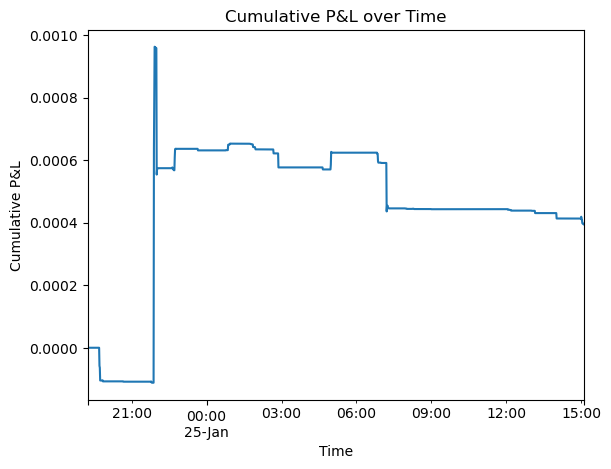

In [48]:
T = '50s'  
sharpe_ratio_ETH_BTC, max_drawdown_ETH_BTC, downside_deviations_ETH_BTC, cumulative_plT_ETH_BTC, grouped_plt_ETH_BTC = calculate_pnl_stats(pnl_ETH_BTC, T)


This graph depicts the cumulative Profit and Loss (P&L) over time. The P&L is positive throughout the observed period, suggesting that the investment or trading strategy has been profitable. 

In [49]:
sharpe_ratio_ETH_BTC

0.011519161755932407

In [50]:
max_drawdown_ETH_BTC

0.0005687076158850351

In [51]:
downside_deviations_ETH_BTC

4.7479605287615444e-05

The Sharpe ratio is 0.012, which is positive but relatively low. This suggests that the excess return of the strategy over the risk-free rate is not very high when taking into account the volatility of the returns.

Here, the max drawdown is very small, indicating that the largest drop in value from a peak was minimal, which suggests low downside volatility and risk in the context of this strategy.

The downside deviation is a very small number indicating that the downside risk of the strategy is low. Overall, these statistics indicate that the trading strategy or investment in the ETH-BTC pair has been profitable over the specified period, with a positive (though low) risk-adjusted return, minimal maximum drawdown, and very low downside risk.

Pnl stats with trading costs:

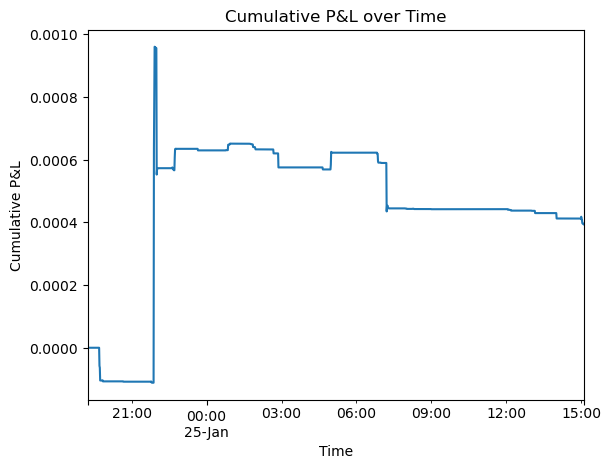

In [52]:
T = '50s'  
sharpe_ratio_ETH_BTC_tc, max_drawdown_ETH_BTC_tc, downside_deviations_ETH_BTC_tc, cumulative_plT_ETH_BTC_tc, grouped_plt_ETH_BTC_tc = calculate_pnl_stats(pnl_ETH_BTC_with_tc, T)


In [53]:
sharpe_ratio_ETH_BTC_tc



0.011519161755932972

In [54]:
max_drawdown_ETH_BTC_tc



0.0005675702006532655

In [55]:
downside_deviations_ETH_BTC_tc

4.7384646077040235e-05

From the above plots we can say that the pnl stats hardly change after considering the trading costs.

# 4. Anaysis of BTC-USD pair:

Reading the trades and book data:

In [56]:
#Reading the trades data BTC-USD
trades_file_path1 = r'C:\Users\nihar\Desktop\QTS\Week 4 Tick Level Data\Assignment 4\trades_narrow_BTC-USD_2023.delim.gz'
trades_BTC_USD = pd.read_csv(trades_file_path1, delimiter='\t')

In [57]:
trades_BTC_USD.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1674521267814309000,1674521267874527000,22970120000,87069600,-1
1,1674521267814046000,1674521267874527000,22970150000,25797600,-1
2,1674521267817981000,1674521267878712000,22970120000,10,-1
3,1674521267822734000,1674521267886114000,22969160000,217683140,-1
4,1674521274845338000,1674521268676444000,22969840000,10000000,1


In [58]:
trades_BTC_USD.shape

(560107, 5)

In [59]:
#Reading the book data BTC-USD
book_narrow_file_path1 = r'C:\Users\nihar\Desktop\QTS\Week 4 Tick Level Data\Assignment 4\book_narrow_BTC-USD_2023.delim.gz'
book_narrow_BTC_USD = pd.read_csv(book_narrow_file_path1, delimiter='\t')

In [60]:
book_narrow_BTC_USD.head()

,Ask1PriceMillionths,Bid1PriceMillionths,Ask1SizeBillionths,Bid1SizeBillionths,Ask2PriceMillionths,Bid2PriceMillionths,Ask2SizeBillionths,Bid2SizeBillionths,received_utc_nanoseconds,timestamp_utc_nanoseconds,Mid
0,22972550000,22970150000,210000000,25797600,22972560000,22970120000,210000000,87069610,1674521267750919800,1674521267806932000,2.297135e+10
1,22972550000,22970150000,410000000,25797600,22972560000,22970120000,210000000,87069610,1674521267751154000,1674521267807073000,2.297135e+10
2,22972550000,22970150000,410000000,25797600,22972560000,22970120000,210000000,87069610,1674521267752363000,1674521267813516000,2.297135e+10
3,22972540000,22970150000,210000000,25797600,22972550000,22970120000,410000000,87069610,1674521267763308000,1674521267819272000,2.297134e+10
4,22972540000,22970150000,210000000,25797600,22972550000,22970120000,410000000,87069610,1674521267764161000,1674521267825538000,2.297134e+10


In [61]:
book_narrow_BTC_USD.shape

(10700412, 11)

Sorting the datasets by timestamps and remove the duplicates by keeping the latest value:

In [62]:
# Sort by 'timestamp_utc_nanoseconds' in descending order to ensure the latest entries are first
trades_BTC_USD.sort_values(by='timestamp_utc_nanoseconds', ascending=False, inplace=True)

trades_BTC_USD.drop_duplicates(subset=['timestamp_utc_nanoseconds'], keep='first', inplace=True)

trades_BTC_USD.sort_values(by='timestamp_utc_nanoseconds', ascending=True, inplace=True)


# Calling the trade flow function to calculate trade flow for BTC-USD pair:

In [63]:
trades_BTC_USD = trade_flow(trades_BTC_USD,  time_col='timestamp_utc_nanoseconds', size_col='SizeBillionths', sign_col='Side', tau='250s')

# Calculating the T-second forward returns:

In [64]:
trades_BTC_USD = T_second_forward_return(trades_BTC_USD, book_narrow_BTC_USD, trade_price_col = 'PriceMillionths', mid_price_col = 'Mid', time_col = 'timestamp_utc_nanoseconds', T = '100s')

In [65]:
trades_BTC_USD.shape

(369484, 8)

In [66]:
trades_BTC_USD.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return
0,1674521267814046000,1674521267874527000,22970150000,25797600,-1,-25797600,NaN,-0.000410
1,1674521267817981000,1674521267878712000,22970120000,10,-1,-10,-0.025798,-0.000409
2,1674521267822734000,1674521267886114000,22969160000,217683140,-1,-217683140,-0.025798,-0.000367
3,1674521274846837000,1674521268676444000,22969870000,108839400,2,108839400,-0.243481,-0.000390
4,1674521274882897000,1674521268812951000,22967670000,1318360,-1,-1318360,-0.134641,-0.000294


Looking at the data to check for nan vallues before regression:

In [67]:
trades_BTC_USD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369484 entries, 0 to 369483
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   received_utc_nanoseconds   369484 non-null  int64  
 1   timestamp_utc_nanoseconds  369484 non-null  int64  
 2   PriceMillionths            369484 non-null  int64  
 3   SizeBillionths             369484 non-null  int64  
 4   Side                       369484 non-null  int64  
 5   cum_size_billionths        369484 non-null  int64  
 6   trade_flow                 369462 non-null  float64
 7   T_second_forward_return    369484 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 22.6 MB


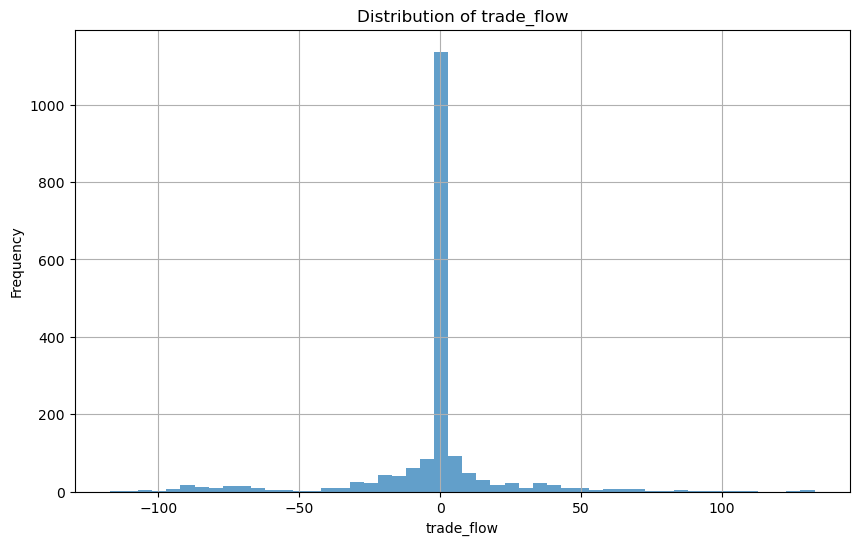

In [68]:
plt.figure(figsize=(10, 6))
plt.hist(trades_ETH_BTC['trade_flow'].dropna(), bins=50, alpha=0.7)
plt.title('Distribution of trade_flow')
plt.xlabel('trade_flow')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Fill the nan values for trade flow by keeping the distribution of trade flow the same:

In [69]:
# Fill NaN values in 'trade_flow' with the median value
median_flow1 = trades_BTC_USD['trade_flow'].median()
trades_BTC_USD['trade_flow'].fillna(median_flow1, inplace=True)

In [70]:
trades_BTC_USD.describe()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return
count,3.694840e+05,3.694840e+05,3.694840e+05,3.694840e+05,369484.000000,3.694840e+05,369484.000000,369484.000000
mean,1.674589e+18,1.674589e+18,2.284267e+10,5.723075e+07,0.195879,2.020872e+06,1.388053,0.000053
std,3.921944e+13,3.921943e+13,1.923851e+08,1.706227e+08,1.135098,1.799539e+08,16.004254,0.001247
min,1.674521e+18,1.674521e+18,2.233863e+10,1.000000e+01,-22.000000,-2.744100e+10,-118.384993,-0.005549
25%,1.674558e+18,1.674558e+18,2.265870e+10,1.128275e+06,-1.000000,-7.680872e+06,-2.999456,-0.000519
50%,1.674587e+18,1.674587e+18,2.289620e+10,1.000000e+07,1.000000,2.997600e+05,2.350975,0.000011
75%,1.674619e+18,1.674619e+18,2.300069e+10,4.800000e+07,1.000000,1.000000e+07,7.514758,0.000531
max,1.674662e+18,1.674662e+18,2.316556e+10,2.744100e+10,10.000000,9.146450e+09,94.506012,0.008234


Splitting the dataset into training and test data:

In [71]:
train_BTC_USD, test_BTC_USD = train_test_data(trades_BTC_USD, train_size=0.6)

In [72]:
train_BTC_USD.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return
0,1674521267814046000,1674521267874527000,22970150000,25797600,-1,-25797600,2.350975,-0.000410
1,1674521267817981000,1674521267878712000,22970120000,10,-1,-10,-0.025798,-0.000409
2,1674521267822734000,1674521267886114000,22969160000,217683140,-1,-217683140,-0.025798,-0.000367
3,1674521274846837000,1674521268676444000,22969870000,108839400,2,108839400,-0.243481,-0.000390
4,1674521274882897000,1674521268812951000,22967670000,1318360,-1,-1318360,-0.134641,-0.000294


Checking for percentage for training and test data:

In [73]:
print(f"Training set length: {len(train_BTC_USD)}")
print(f"Testing set length: {len(test_BTC_USD)}")

Training set length: 221690
Testing set length: 147794


# Calling the regression function:

In [74]:
beta_BTC_USD, test_pred_BTC_USD, r2_BTC_USD = regression(train_BTC_USD, test_BTC_USD, flow_col='trade_flow', return_col='T_second_forward_return')

In [75]:
r2_BTC_USD


0.0009130990390580074

In [76]:
beta_BTC_USD

-1.7358470467690053e-06

# Calculate beta for various tau and T pairs:

In [77]:
tau_T_pairs1 = [('5s', '1s'), ('10s', '5s'), ('15s', '10s'), ('20s', '15s'), ('25s', '20s'), ('30s', '25s'), ('35s', '30s'), ('40s', '30s'), ('50s', '40s'), ('60s', '50s'), ('100s', '80s')]

In [78]:
beta_values1 = {}

# Loop through each pair of tau and T
for tau, T in tau_T_pairs1:
    beta1 = pipeline(trades_BTC_USD, book_narrow_BTC_USD, 
                    time_col='timestamp_utc_nanoseconds',
                    size_col='SizeBillionths', 
                    sign_col='Side', 
                    trade_price_col='PriceMillionths', 
                    mid_price_col='Mid', 
                    tau=tau, T=T, 
                    train_size=0.4)
    # Store the beta value in the dictionary
    beta_values1[(tau, T)] = beta1

beta_records = [{'tau': tau, 'T': T, 'beta': beta1} for (tau, T), beta1 in beta_values1.items()]

# Create a DataFrame
beta_df1 = pd.DataFrame(beta_records)

# Display the DataFrame
print(beta_df1)

     tau    T      beta
0     5s   1s -0.000007
1    10s   5s -0.000010
2    15s  10s -0.000010
3    20s  15s -0.000006
4    25s  20s -0.000003
5    30s  25s -0.000004
6    35s  30s -0.000004
7    40s  30s -0.000005
8    50s  40s -0.000007
9    60s  50s -0.000010
10  100s  80s -0.000011


# Looking at the reliability and stability of beta:

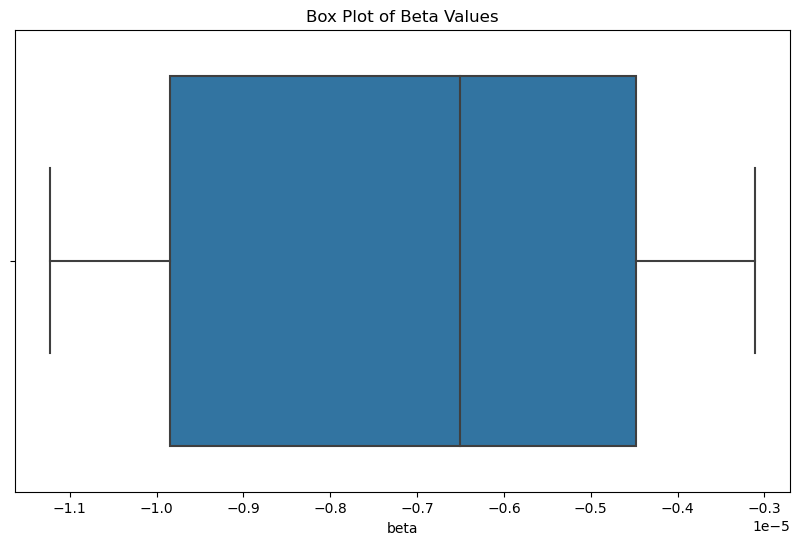

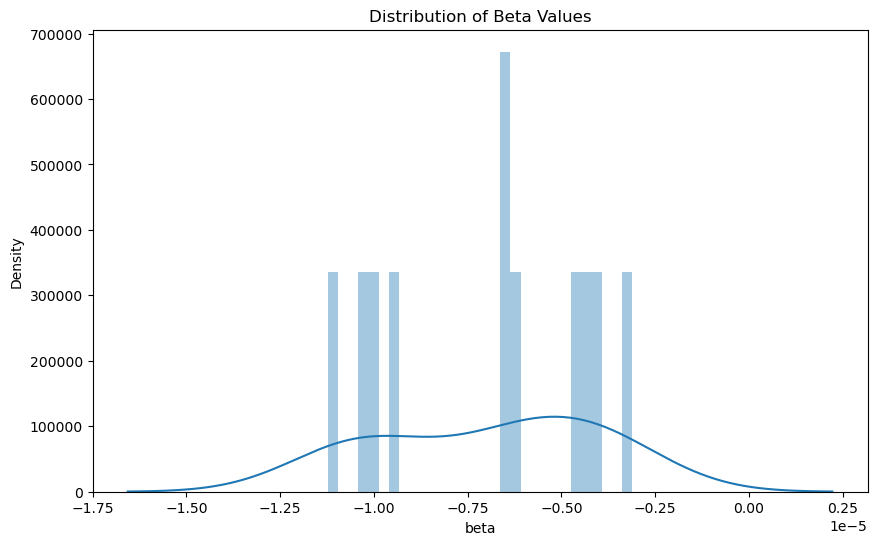

{'Coefficient of Variation': -0.4132471003240253, 'Beta Standard Deviation': 2.8758531017948895e-06, 'Beta Range': 8.113192837143382e-06}


In [79]:
rel_stab_beta1 = analyze_beta_stability(beta_df1)
print(rel_stab_beta1)

From the plot we can see that, beta doesn't varies that much as we change the tau and T intervals.

# Various beta for different training sizes by considering best tau and T:

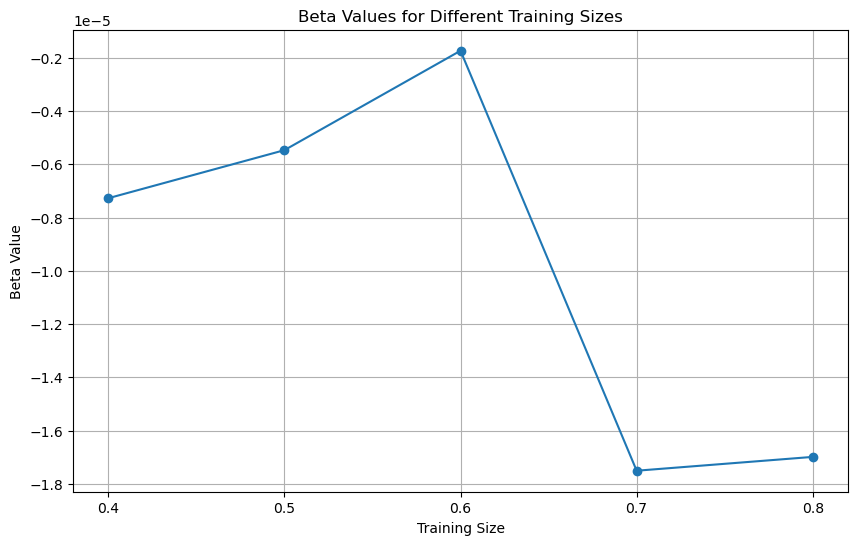

In [80]:
best_tau1 = '250s'
best_T1 = '100s'

# Define the range of training sizes
train_sizes1 = [0.4, 0.5, 0.6, 0.7, 0.8]

# Initialize an empty list to store the results
beta_values2 = []

# Loop over the training sizes
for train_size in train_sizes1:
    beta = pipeline(trades_BTC_USD, book_narrow_BTC_USD, 
                    time_col='timestamp_utc_nanoseconds',
                    size_col='SizeBillionths', 
                    sign_col='Side', 
                    trade_price_col='PriceMillionths', 
                    mid_price_col='Mid', 
                    tau=best_tau1, T=best_T1, 
                    train_size=train_size)
    beta_values2.append(beta)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_sizes1, beta_values2, marker='o')
plt.title('Beta Values for Different Training Sizes')
plt.xlabel('Training Size')
plt.ylabel('Beta Value')
plt.xticks(train_sizes1)
plt.grid(True)
plt.show()

# Look at the return prediction from the regression function:

In [81]:
test_pred_BTC_USD

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return,predicted_return
221690,1674596253328640000,1674596253364714000,23012210000,839370,1,839370,8.948746,-0.000432,-0.000016
221691,1674596253643133000,1674596253680436000,23012210000,1080980,1,1080980,8.963564,-0.000444,-0.000016
221692,1674596253742026000,1674596253779376000,23011840000,2928430,-1,-2928430,8.963326,-0.000426,-0.000016
221693,1674596254090794000,1674596254126242000,23012170000,87280,1,87280,8.956204,-0.000441,-0.000016
221694,1674596254528000000,1674596254565429000,23011860000,193530,-1,-193530,8.954798,-0.000438,-0.000016
...,...,...,...,...,...,...,...,...,...
369479,1674661801474245000,1674661801477570000,22573080000,920730,1,920730,5.986970,-0.000110,-0.000010
369480,1674661801534824000,1674661801543105000,22571970000,335000000,-1,-335000000,5.987891,-0.000060,-0.000010
369481,1674661801592039000,1674661801601688000,22570920000,50000000,-1,-50000000,5.655578,-0.000014,-0.000010
369482,1674661801592674000,1674661801601719000,22570920000,32600000,-1,-32600000,5.605578,-0.000014,-0.000010


In [82]:
test_pred_BTC_USD['predicted_return'].describe()

count    147794.000000
mean          0.000002
std           0.000030
min          -0.000164
25%          -0.000010
50%          -0.000002
75%           0.000008
max           0.000205
Name: predicted_return, dtype: float64

# Deciding j:

j has been decided in such a way that trade can be performed 30% of the time:

In [83]:
# Calculate the absolute values of the predicted returns
absolute_predicted_returns1 = test_pred_BTC_USD['predicted_return'].abs()

# Find the value of j such that 70% of the predicted returns are greater than j
j_BTC_USD = np.percentile(absolute_predicted_returns1, 70)  # 70th percentile since we want the lower threshold

j_BTC_USD

1.5646840424428772e-05

Finding trade signals for the decided j:

In [84]:
test_pred_BTC_USD = find_trade_signals(test_pred_BTC_USD, predicted_return_col='predicted_return', j=j_BTC_USD)

In [85]:
test_pred_BTC_USD.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return,predicted_return,trade_signal
221690,1674596253328640000,1674596253364714000,23012210000,839370,1,839370,8.948746,-0.000432,-0.000016,False
221691,1674596253643133000,1674596253680436000,23012210000,1080980,1,1080980,8.963564,-0.000444,-0.000016,False
221692,1674596253742026000,1674596253779376000,23011840000,2928430,-1,-2928430,8.963326,-0.000426,-0.000016,False
221693,1674596254090794000,1674596254126242000,23012170000,87280,1,87280,8.956204,-0.000441,-0.000016,False
221694,1674596254528000000,1674596254565429000,23011860000,193530,-1,-193530,8.954798,-0.000438,-0.000016,False


In [86]:
test_pred_BTC_USD['trade_signal'].value_counts()

trade_signal
False    103456
True      44338
Name: count, dtype: int64

# Creating the pnl dataframe:

In [87]:

pnl_BTC_USD = calculate_pnl(test_pred_BTC_USD, book_narrow_BTC_USD, T = '40s', position_size=0.1)

pnl_BTC_USD

,timestamp_utc_nanoseconds,position,PriceMillionths,Mid,acc_qty,plT,acc_plT
0,1674596263779157000,0.008691,23011.48,23011.055,0.000000e+00,-0.003694,0.000000
1,1674596263791059000,0.020600,23011.31,23011.060,8.691000e+06,-0.005150,-0.003694
2,1674596264682806000,0.000056,23011.48,23011.195,2.929100e+07,-0.000016,-0.008844
3,1674596264741925000,0.002252,23011.48,23011.210,2.934734e+07,-0.000608,-0.008860
4,1674596265064895000,0.010000,23011.48,23011.245,3.159903e+07,-0.002350,-0.009468
...,...,...,...,...,...,...,...
44333,1674661788120435000,0.000059,22581.95,22580.615,-8.389503e+09,-0.000079,-665.218917
44334,1674661788162403000,0.000431,22581.69,22579.900,-8.389444e+09,-0.000772,-665.218996
44335,1674661788781066000,-0.050000,22580.48,22579.850,-8.389013e+09,0.031500,-665.219768
44336,1674661789498108000,0.000210,22580.14,22579.155,-8.439013e+09,-0.000207,-665.188268


Pnl with trading costs:

In [88]:
pnl_BTC_USD_with_tc = calculate_pnl_with_tc(test_pred_BTC_USD, book_narrow_BTC_USD, T = '50s', position_size=0.1)

pnl_BTC_USD_with_tc

,timestamp_utc_nanoseconds,position,PriceMillionths,Mid,acc_qty,plT,acc_plT
0,1674596263779157000,0.008691,23011.48,23011.055,0.000000e+00,-0.003686,0.000000
1,1674596263791059000,0.020600,23011.31,23011.060,8.691000e+06,-0.005140,-0.003686
2,1674596264682806000,0.000056,23011.48,23011.195,2.929100e+07,-0.000016,-0.008826
3,1674596264741925000,0.002252,23011.48,23011.210,2.934734e+07,-0.000607,-0.008842
4,1674596265064895000,0.010000,23011.48,23011.245,3.159903e+07,-0.002345,-0.009449
...,...,...,...,...,...,...,...
44333,1674661788120435000,0.000059,22581.95,22580.615,-8.389503e+09,-0.000079,-663.888479
44334,1674661788162403000,0.000431,22581.69,22579.900,-8.389444e+09,-0.000770,-663.888558
44335,1674661788781066000,-0.050000,22580.48,22579.850,-8.389013e+09,0.031437,-663.889328
44336,1674661789498108000,0.000210,22580.14,22579.155,-8.439013e+09,-0.000207,-663.857891


# Calculating pnl stats:

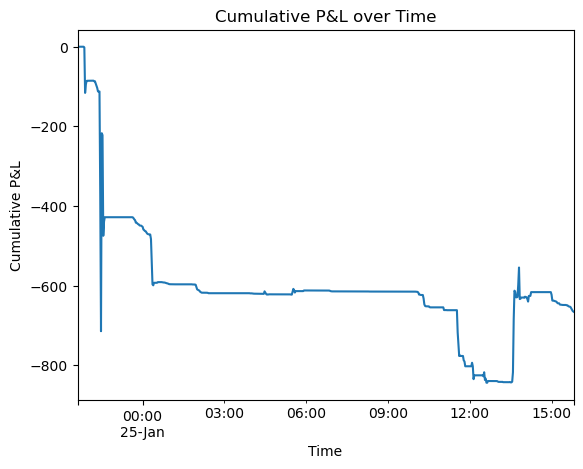

In [89]:
T = '100s'  
sharpe_ratio_BTC_USD, max_drawdown_BTC_USD, downside_deviations_BTC_USD, cumulative_plT_BTC_USD, grouped_plt_BTC_USD = calculate_pnl_stats(pnl_BTC_USD, T)

This graph represents the cumulative Profit and Loss (P&L) over a certain period and we can see a negative P&L for the time period.

In [90]:
sharpe_ratio_BTC_USD

-0.03475661657835804

In [91]:
max_drawdown_BTC_USD

843.3846688235889

In [92]:
downside_deviations_BTC_USD

40.26791120903213

As we have a negative Sharpe ratio of -0.057 which suggests that the investment is performing worse than the risk-free rate when adjusted for volatility. 

The maximum drawdown value of 1406.753 indicates the largest loss that would have been experienced if an investment was made at the peak value before the largest drop.

The downside deviation value of 33.566 suggests that there is a level of downside volatility in the returns of the investment.

In summary, these statistics indicate a trading strategy or investment in BTC against the USD that is currently underperforming, with significant losses (as shown by the cumulative P&L), a negative risk-adjusted return (Sharpe ratio), a significant maximum drawdown, and a measure of downside risk (downside deviation).

Pnl stats with trading costs:

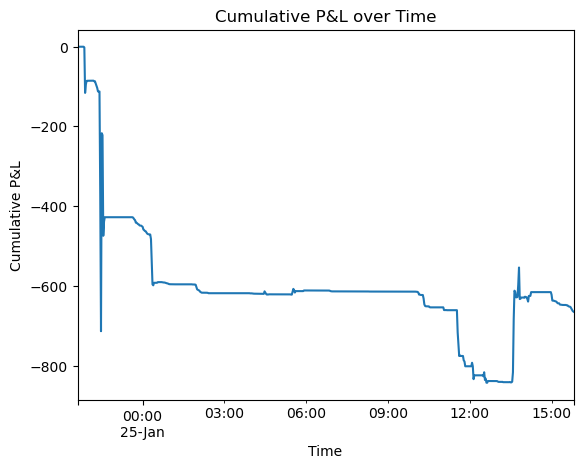

In [93]:
T = '100s'  
sharpe_ratio_BTC_USD_tc, max_drawdown_BTC_USD_tc, downside_deviations_BTC_USD_tc, cumulative_plT_BTC_USD_tc, grouped_plt_BTC_USD_tc = calculate_pnl_stats(pnl_BTC_USD_with_tc, T)

In [94]:
sharpe_ratio_BTC_USD_tc

-0.03475661657835839

In [95]:
max_drawdown_BTC_USD_tc

841.6978994859418

In [96]:
downside_deviations_BTC_USD_tc

40.18737538661405

# 5. Analysis of ETH-USD pair:

Reading the trade and book data:

In [97]:
#Reading the trades data ETH-USD
trades_file_path2 = r'C:\Users\nihar\Desktop\QTS\Week 4 Tick Level Data\Assignment 4\trades_narrow_ETH-USD_2023.delim.gz'
trades_ETH_USD = pd.read_csv(trades_file_path2, delimiter='\t')

In [98]:
trades_ETH_USD.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1674521275236165000,1674521271071902000,1629670000,11815210,-1
1,1674521275287511000,1674521271398509000,1629770000,92158690,1
2,1674521275288004000,1674521271398509000,1629780000,712594890,2
3,1674521275288470000,1674521271398509000,1629790000,1016994240,2
4,1674521275330683000,1674521271578052000,1629770000,92150000,1


In [99]:
trades_ETH_USD.shape

(377185, 5)

In [100]:
#Reading the book data ETH-USD
book_narrow_file_path2 = r'C:\Users\nihar\Desktop\QTS\Week 4 Tick Level Data\Assignment 4\book_narrow_ETH-USD_2023.delim.gz'
book_narrow_ETH_USD = pd.read_csv(book_narrow_file_path2, delimiter='\t')

In [101]:
book_narrow_ETH_USD.head()

,Ask1PriceMillionths,Bid1PriceMillionths,Ask1SizeBillionths,Bid1SizeBillionths,Ask2PriceMillionths,Bid2PriceMillionths,Ask2SizeBillionths,Bid2SizeBillionths,received_utc_nanoseconds,timestamp_utc_nanoseconds,Mid
0,1629780000,1629670000,613579740,46580250,1629790000,1629660000,920369620,40425010,1674521275215127000,1674521271006006000,1.629725e+09
1,1629780000,1629670000,613579740,46580250,1629790000,1629660000,920369620,125425010,1674521275215372000,1674521271008923000,1.629725e+09
2,1629780000,1629670000,613579740,346580250,1629790000,1629660000,920369620,125425010,1674521275216940000,1674521271013030000,1.629725e+09
3,1629780000,1629670000,613579740,334765040,1629790000,1629660000,920369620,125425010,1674521275236165000,1674521271071902000,1.629725e+09
4,1629770000,1629670000,92158690,334765040,1629780000,1629660000,613579740,125425010,1674521275257733000,1674521271167792000,1.629720e+09


In [102]:
book_narrow_ETH_USD.shape

(6250325, 11)

Sorting the datasets by timestamps and remove the duplicates by keeping the latest value:

In [103]:
# Sort by 'timestamp_utc_nanoseconds' in descending order to ensure the latest entries are first
trades_ETH_USD.sort_values(by='timestamp_utc_nanoseconds', ascending=False, inplace=True)

trades_ETH_USD.drop_duplicates(subset=['timestamp_utc_nanoseconds'], keep='first', inplace=True)

trades_ETH_USD.sort_values(by='timestamp_utc_nanoseconds', ascending=True, inplace=True)

# Calling the trade flow function to calculate trade flow for BTC-USD pair:

In [104]:
trades_ETH_USD = trade_flow(trades_ETH_USD,  time_col='timestamp_utc_nanoseconds', size_col='SizeBillionths', sign_col='Side', tau='50s')

# Calculating the T-second forward returns:

In [105]:
trades_ETH_USD = T_second_forward_return(trades_ETH_USD, book_narrow_ETH_USD, trade_price_col = 'PriceMillionths', mid_price_col = 'Mid', time_col = 'timestamp_utc_nanoseconds', T = '40s')


In [106]:
trades_ETH_USD.shape

(250247, 8)

In [107]:
trades_ETH_USD.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return
0,1674521275236165000,1674521271071902000,1629670000,11815210,-1,-11815210,NaN,-0.000187
1,1674521275288004000,1674521271398509000,1629780000,712594890,2,712594890,-0.011815,-0.000233
2,1674521275330683000,1674521271578052000,1629770000,92150000,1,92150000,0.700780,-0.000236
3,1674521275353309000,1674521271660995000,1629770000,8690,1,8690,0.792930,-0.000236
4,1674521275440899000,1674521271885174000,1629820000,14730,1,14730,0.792938,-0.000350


Looking at the data to check for nan vallues before regression:

In [108]:
trades_ETH_USD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250247 entries, 0 to 250246
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   received_utc_nanoseconds   250247 non-null  int64  
 1   timestamp_utc_nanoseconds  250247 non-null  int64  
 2   PriceMillionths            250247 non-null  int64  
 3   SizeBillionths             250247 non-null  int64  
 4   Side                       250247 non-null  int64  
 5   cum_size_billionths        250247 non-null  int64  
 6   trade_flow                 250215 non-null  float64
 7   T_second_forward_return    250247 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 15.3 MB


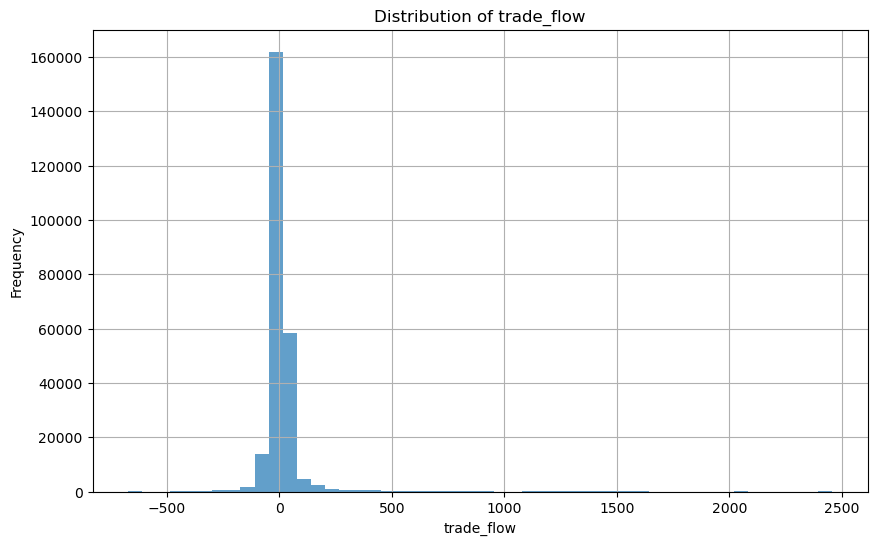

In [109]:
plt.figure(figsize=(10, 6))
plt.hist(trades_ETH_USD['trade_flow'].dropna(), bins=50, alpha=0.7)
plt.title('Distribution of trade_flow')
plt.xlabel('trade_flow')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Fill the nan values for trade flow by keeping the distribution of trade flow the same:

In [110]:
# Fill NaN values in 'trade_flow' with the median value
median_flow2 = trades_ETH_USD['trade_flow'].median()
trades_ETH_USD['trade_flow'].fillna(median_flow2, inplace=True)

In [111]:
trades_ETH_USD.describe()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return
count,2.502470e+05,2.502470e+05,2.502470e+05,2.502470e+05,250247.000000,2.502470e+05,250247.000000,250247.000000
mean,1.674594e+18,1.674594e+18,1.588670e+09,5.701886e+08,0.111873,3.018784e+07,14.135830,0.000023
std,3.729694e+13,3.729693e+13,3.776572e+07,2.279291e+09,1.303092,2.349335e+09,135.761719,0.000654
min,1.674521e+18,1.674521e+18,1.532690e+09,1.000000e+01,-36.000000,-2.965000e+11,-673.872546,-0.010397
25%,1.674563e+18,1.674563e+18,1.550290e+09,2.675000e+07,-1.000000,-1.286201e+08,-16.261033,-0.000244
50%,1.674593e+18,1.674593e+18,1.611540e+09,1.269600e+08,1.000000,1.163840e+06,0.520085,0.000021
75%,1.674628e+18,1.674628e+18,1.621865e+09,5.000000e+08,1.000000,1.257633e+08,18.001205,0.000290
max,1.674659e+18,1.674659e+18,1.640540e+09,3.403621e+11,7.000000,3.403621e+11,2457.693805,0.003772


Splitting the dataset into training and test data:

In [112]:
train_ETH_USD, test_ETH_USD = train_test_data(trades_ETH_USD, train_size=0.6)

In [113]:
train_ETH_USD.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return
0,1674521275236165000,1674521271071902000,1629670000,11815210,-1,-11815210,0.520085,-0.000187
1,1674521275288004000,1674521271398509000,1629780000,712594890,2,712594890,-0.011815,-0.000233
2,1674521275330683000,1674521271578052000,1629770000,92150000,1,92150000,0.700780,-0.000236
3,1674521275353309000,1674521271660995000,1629770000,8690,1,8690,0.792930,-0.000236
4,1674521275440899000,1674521271885174000,1629820000,14730,1,14730,0.792938,-0.000350


Checking for percentage for training and test data:

In [114]:
print(f"Training set length: {len(train_ETH_USD)}")
print(f"Testing set length: {len(test_ETH_USD)}")

Training set length: 150148
Testing set length: 100099


# Calling the regression function:

In [115]:
beta_ETH_USD, test_pred_ETH_USD, r2_ETH_USD = regression(train_ETH_USD, test_ETH_USD, flow_col='trade_flow', return_col='T_second_forward_return')

In [116]:
r2_ETH_USD

0.005163439326293151

In [117]:
beta_ETH_USD

3.2580236370689353e-07

# Calculate beta for various tau and T pairs:

In [118]:
tau_T_pairs2 = [('5s', '1s'), ('10s', '5s'), ('15s', '10s'), ('20s', '15s'), ('25s', '20s'), ('30s', '25s'), ('35s', '30s'), ('40s', '30s'), ('50s', '40s'), ('60s', '50s'), ('100s', '80s')]

beta_values2 = {}

# Loop through each pair of tau and T
for tau, T in tau_T_pairs2:
    beta2 = pipeline(trades_ETH_USD, book_narrow_ETH_USD, 
                    time_col='timestamp_utc_nanoseconds',
                    size_col='SizeBillionths', 
                    sign_col='Side', 
                    trade_price_col='PriceMillionths', 
                    mid_price_col='Mid', 
                    tau=tau, T=T, 
                    train_size=0.4)
    # Store the beta value in the dictionary
    beta_values2[(tau, T)] = beta2

beta_records = [{'tau': tau, 'T': T, 'beta': beta1} for (tau, T), beta2 in beta_values2.items()]

# Create a DataFrame
beta_df2 = pd.DataFrame(beta_records)

# Display the DataFrame
print(beta_df2)

     tau    T      beta
0     5s   1s -0.000011
1    10s   5s -0.000011
2    15s  10s -0.000011
3    20s  15s -0.000011
4    25s  20s -0.000011
5    30s  25s -0.000011
6    35s  30s -0.000011
7    40s  30s -0.000011
8    50s  40s -0.000011
9    60s  50s -0.000011
10  100s  80s -0.000011


# Looking at the reliability and stability of beta:

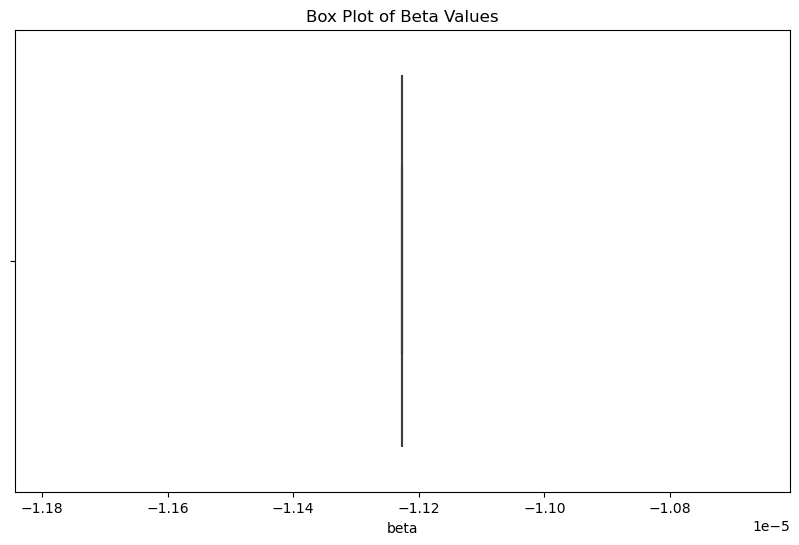

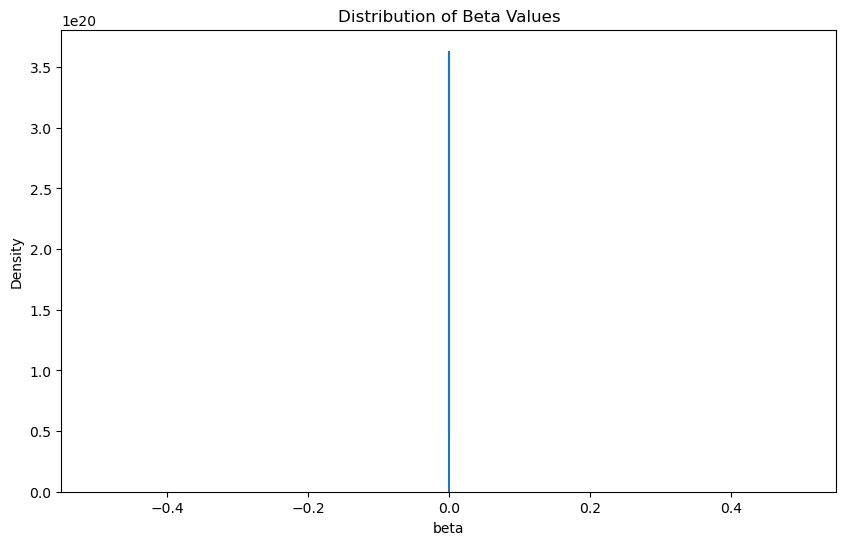

{'Coefficient of Variation': -3.1653543813102167e-16, 'Beta Standard Deviation': 3.553502599087806e-21, 'Beta Range': 0.0}


In [119]:
rel_stab_beta2 = analyze_beta_stability(beta_df2)
print(rel_stab_beta2)

The above plots shows that the beta is constant irrespective of any tau interval or T-seconds. 

# Various beta for different training sizes by considering best tau and T:

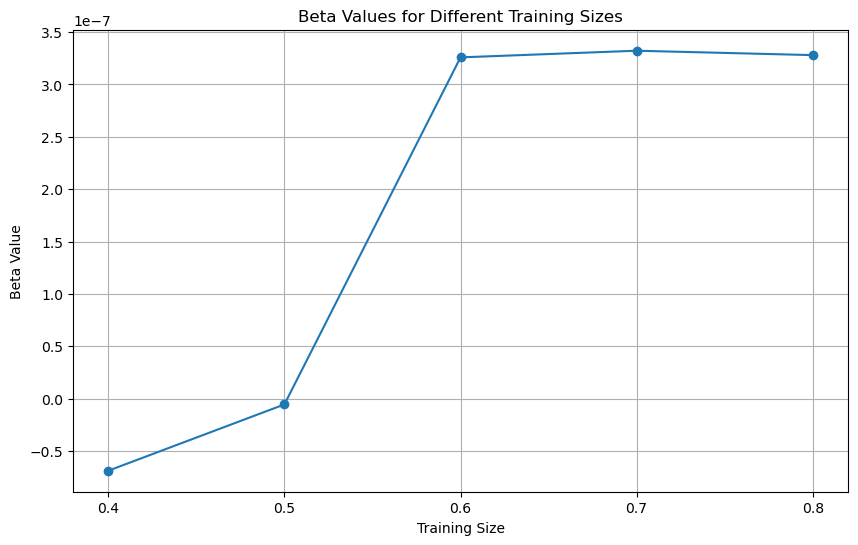

In [120]:
best_tau2 = '50s'
best_T2 = '40s'

# Define the range of training sizes
train_sizes2 = [0.4, 0.5, 0.6, 0.7, 0.8]

# Initialize an empty list to store the results
beta_values3 = []

# Loop over the training sizes
for train_size in train_sizes2:
    beta = pipeline(trades_ETH_USD, book_narrow_ETH_USD, 
                    time_col='timestamp_utc_nanoseconds',
                    size_col='SizeBillionths', 
                    sign_col='Side', 
                    trade_price_col='PriceMillionths', 
                    mid_price_col='Mid', 
                    tau=best_tau2, T=best_T2, 
                    train_size=train_size)
    beta_values3.append(beta)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_sizes2, beta_values3, marker='o')
plt.title('Beta Values for Different Training Sizes')
plt.xlabel('Training Size')
plt.ylabel('Beta Value')
plt.xticks(train_sizes2)
plt.grid(True)
plt.show()

Beta increases as we increase the training dataset size from 0.4 onwards.

# Look at the return prediction from the regression function:

In [121]:
test_pred_ETH_USD

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return,predicted_return
150148,1674611369168175000,1674611369197642000,1535360000,1081570000,-2,-1081570000,-34.261109,-0.000257,-0.000011
150149,1674611369227140000,1674611369259017000,1535340000,258150000,-1,-258150000,-35.342679,-0.000244,-0.000012
150150,1674611369827708000,1674611369859465000,1535370000,420000000,3,420000000,-35.600829,-0.000251,-0.000012
150151,1674611369945694000,1674611369978466000,1535370000,30956440,1,30956440,-35.625215,-0.000247,-0.000012
150152,1674611370202075000,1674611370233612000,1535260000,2110000000,-1,-2110000000,-36.160644,-0.000199,-0.000012
...,...,...,...,...,...,...,...,...,...
250242,1674658830282701000,1674658830318655000,1533330000,631563540,1,631563540,-16.202779,0.000717,-0.000005
250243,1674658830285405000,1674658830318708000,1533340000,5056896150,3,5056896150,-15.571215,0.000711,-0.000005
250244,1674658830287086000,1674658830319185000,1533310000,2095786600,1,2095786600,-10.514319,0.000730,-0.000003
250245,1674658830299074000,1674658830330265000,1533310000,1181857040,2,1181857040,-8.418532,0.000730,-0.000003


In [122]:
test_pred_ETH_USD['predicted_return'].describe()

count    1.000990e+05
mean     2.735045e-06
std      2.335230e-05
min     -1.032815e-04
25%     -5.242539e-06
50%      9.176740e-07
75%      6.886054e-06
max      2.352827e-04
Name: predicted_return, dtype: float64

# Deciding j:

j has been decided in such a way that trade can be performed 30% of the time:

In [123]:
# Calculate the absolute values of the predicted returns
absolute_predicted_returns2 = test_pred_ETH_USD['predicted_return'].abs()

# Find the value of j such that 70% of the predicted returns are greater than j
j_ETH_USD = np.percentile(absolute_predicted_returns2, 70)  # 70th percentile since we want the lower threshold

j_ETH_USD

1.0212049485939407e-05

Finding trade signals for the decided j:

In [124]:
test_pred_ETH_USD = find_trade_signals(test_pred_ETH_USD, predicted_return_col='predicted_return', j=j_ETH_USD)

In [125]:
test_pred_ETH_USD.head(20)

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,cum_size_billionths,trade_flow,T_second_forward_return,predicted_return,trade_signal
150148,1674611369168175000,1674611369197642000,1535360000,1081570000,-2,-1081570000,-34.261109,-0.000257,-0.000011,True
150149,1674611369227140000,1674611369259017000,1535340000,258150000,-1,-258150000,-35.342679,-0.000244,-0.000012,True
150150,1674611369827708000,1674611369859465000,1535370000,420000000,3,420000000,-35.600829,-0.000251,-0.000012,True
150151,1674611369945694000,1674611369978466000,1535370000,30956440,1,30956440,-35.625215,-0.000247,-0.000012,True
150152,1674611370202075000,1674611370233612000,1535260000,2110000000,-1,-2110000000,-36.160644,-0.000199,-0.000012,True
150153,1674611370890735000,1674611370919297000,1535250000,31728920,1,31728920,-38.270644,-0.000192,-0.000012,True
150154,1674611371038996000,1674611371071222000,1535040000,1000000000,-1,-1000000000,-38.238915,-0.000059,-0.000012,True
150155,1674611371552573000,1674611371584341000,1534960000,300000000,-1,-300000000,-39.238915,-0.000020,-0.000013,True
150156,1674611373217040000,1674611373246195000,1534780000,500000000,-1,-500000000,-39.974252,0.000081,-0.000013,True
150157,1674611373227034000,1674611373254387000,1534640000,521289100,-1,-521289100,-40.474252,0.000173,-0.000013,True


In [126]:
test_pred_ETH_USD['trade_signal'].value_counts()

trade_signal
False    70069
True     30030
Name: count, dtype: int64

# Creating the pnl dataframe:

In [127]:
pnl_ETH_USD = calculate_pnl(test_pred_ETH_USD, book_narrow_ETH_USD, T = '40s', position_size=0.1)

In [128]:
pnl_ETH_USD

,timestamp_utc_nanoseconds,position,PriceMillionths,Mid,acc_qty,plT,acc_plT
0,1674611369197642000,-0.108157,1535.36,1535.400,0.000000e+00,-0.004326,0.000000
1,1674611369259017000,-0.025815,1535.34,1535.360,-1.081570e+08,-0.000516,-0.004326
2,1674611369859465000,0.042000,1535.37,1535.315,-1.339720e+08,-0.002310,-0.004843
3,1674611369978466000,0.003096,1535.37,1535.315,-9.197200e+07,-0.000170,-0.007153
4,1674611370233612000,-0.211000,1535.26,1535.270,-8.887636e+07,-0.002110,-0.007323
...,...,...,...,...,...,...,...
30025,1674658827958690000,-0.216507,1534.64,1535.165,1.601068e+11,-0.113666,-107.480775
30026,1674658827995187000,-0.044431,1534.64,1535.140,1.598903e+11,-0.022216,-107.594441
30027,1674658828169034000,-0.215420,1534.36,1535.065,1.598458e+11,-0.151871,-107.616657
30028,1674658828203108000,-0.495971,1534.04,1535.060,1.596304e+11,-0.505891,-107.768528


Pnl with trading costs:

In [129]:
pnl_ETH_USD_with_tc = calculate_pnl_with_tc(test_pred_ETH_USD, book_narrow_ETH_USD, T = '40s', position_size=0.1)

pnl_ETH_USD_with_tc

,timestamp_utc_nanoseconds,position,PriceMillionths,Mid,acc_qty,plT,acc_plT
0,1674611369197642000,-0.108157,1535.36,1535.400,0.000000e+00,-0.004318,0.000000
1,1674611369259017000,-0.025815,1535.34,1535.360,-1.081570e+08,-0.000515,-0.004318
2,1674611369859465000,0.042000,1535.37,1535.315,-1.339720e+08,-0.002305,-0.004833
3,1674611369978466000,0.003096,1535.37,1535.315,-9.197200e+07,-0.000170,-0.007138
4,1674611370233612000,-0.211000,1535.26,1535.270,-8.887636e+07,-0.002106,-0.007308
...,...,...,...,...,...,...,...
30025,1674658827958690000,-0.216507,1534.64,1535.165,1.601068e+11,-0.113439,-107.265814
30026,1674658827995187000,-0.044431,1534.64,1535.140,1.598903e+11,-0.022171,-107.379253
30027,1674658828169034000,-0.215420,1534.36,1535.065,1.598458e+11,-0.151567,-107.401424
30028,1674658828203108000,-0.495971,1534.04,1535.060,1.596304e+11,-0.504879,-107.552991


# Calculating pnl stats:

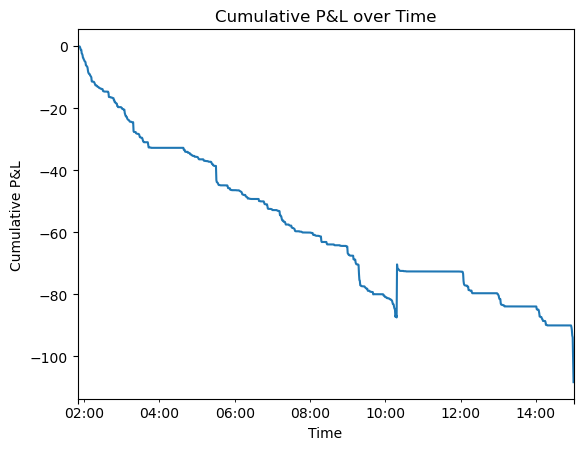

In [130]:
T = '40s'  
sharpe_ratio_ETH_USD, max_drawdown_ETH_USD, downside_deviations_ETH_USD, cumulative_plT_ETH_USD, grouped_plt_ETH_USD = calculate_pnl_stats(pnl_ETH_USD, T)

This graph represents the cumulative Profit and Loss (P&L) over a certain period, likely for a trading strategy. A negative P&L, as shown in the graph, indicates a loss over time. 

In [131]:
sharpe_ratio_ETH_USD

-0.14059533866336874

In [132]:
max_drawdown_ETH_USD

108.32674176187622

In [133]:
downside_deviations_ETH_USD

0.6370404019366247

As we have a negative Sharpe ratio of -0.14059953386636874 which suggests that the investment is performing worse than the risk-free rate when adjusted for volatility. 

The maximum drawdown value of 188.3267417687262 indicates the largest loss that would have been experienced if an investment was made at the peak value before the largest drop.

The downside deviation value of 0.6374048419366247 suggests that there is a level of downside volatility in the returns of the investment.

In summary, these statistics indicate a trading strategy or investment in Ethereum against the USD that is currently underperforming, with significant losses (as shown by the cumulative P&L), a negative risk-adjusted return (Sharpe ratio), a significant maximum drawdown, and a measure of downside risk (downside deviation).

Pnl stats with trading costs:

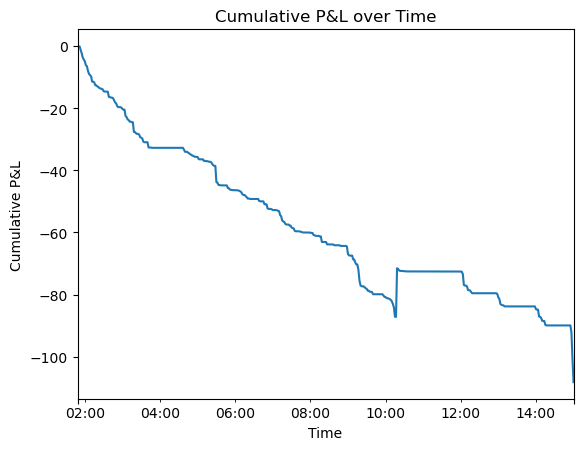

In [134]:
T = '100s'  
sharpe_ratio_ETH_USD_tc, max_drawdown_ETH_USD_tc, downside_deviations_ETH_USD_tc, cumulative_plT_ETH_USD_tc, grouped_plt_ETH_USD_tc = calculate_pnl_stats(pnl_ETH_USD_with_tc, T)

In [135]:
sharpe_ratio_ETH_USD_tc



-0.2199956093436834

In [136]:
max_drawdown_ETH_USD_tc



108.11008827835246

In [137]:
downside_deviations_ETH_USD_tc

0.9528182262954423

# 6. Conclusion:

The analysis has been done for three cryptocurrency pairs and we can see that the strategy for ETH-BTC pair is relatively profitable as compared to BTC-USD and ETH-USD and this can be seen from the sharpe ratio, max drawdown, downside deviation and cumulative pnl plots.

Trade Flow as a Predictor:
The use of trade flow as a predictor for future returns has shown varying degrees of efficacy across the different cryptocurrency pairs. While the methodology for calculating trade flow and predicting forward returns is sound, the actual predictive power, as evidenced by the calculated beta values, varies depending on the pair and the chosen intervals (tau and T).

Beta Stability:
The stability of the beta coefficient varied with different tau and T intervals, suggesting that the relationship between trade flow and future returns is not consistent across different time scales. This implies that the predictive power of trade flow may be more complex than initially assumed and may be influenced by external factors not accounted for in the model.

Training Size Impact:
The size of the training set had a noticeable impact on the beta values, indicating that the amount of historical data used to train the model can influence the predictions. As the training size increased, there was a tendency for beta to increase as well, suggesting that having more data points can potentially lead to stronger predictions. However, this did not necessarily translate into better performance metrics, indicating that more data does not automatically mean more profitable trading signals.

Trading Signal Generation:
The strategy of determining trade signals based on a certain percentile of predicted returns (with j values chosen to activate trading 60% and 30% of the time for the respective pairs) did not lead to consistently profitable outcomes. This could suggest that the threshold for generating signals may need further optimization, or that other factors may need to be considered when deciding when to trade.

Transaction Costs Consideration:
Incorporating transaction costs into the P&L calculations showed that the profitability of trades was further diminished but not significantly when such costs were accounted for.

In conclusion, while the analytical approach and the developed models have potential, the current implementation does not yield profitable trading strategies for the cryptocurrency pairs analyzed. The analysis highlights the need for further refinement of the trade flow-based predictive model, perhaps by incorporating additional market factors, optimizing the model parameters, or employing more sophisticated risk management techniques. Future research could also explore different timeframes, alternative predictive indicators, and the use of machine learning models to improve the accuracy and profitability of the trade signals.